In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from censai import RIMUnet, PhysicalModel, RIM, RIMSharedUnet
from censai.models import VAE, VAESecondStage, SharedUnetModel, UnetModel
from censai.utils import rim_residual_plot, update
from censai.data.lenses_tng import decode_train, decode_physical_model_info
import os, glob, re, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from argparse import Namespace
import math, json
import matplotlib.pylab as pylab
import h5py
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 200)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# NIE no shift

In [7]:
hparamsSUNS = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_NIEns.csv"), index_col=0)
hparamsDUNS = pd.read_csv(os.path.join(result_dir, "RIMDU512_k128_NIEns.csv"), index_col=0)
hparamsSUS  = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_NIEs.csv"), index_col=0)
hparamsDUS  = pd.read_csv(os.path.join(result_dir, "RIMDU512_k128_NIEs.csv"), index_col=0)

columns = ["seed", "batch_size", "total_items", "train_cost", "train_chi_squared", "best_score", "experiment_id"]
hparams = pd.concat([df[columns] for df in [hparamsSUNS, hparamsDUNS, hparamsSUS, hparamsDUS]])
hparams["shift"] = ["ns" not in experiment_id for experiment_id in hparams["experiment_id"]]

# histories = {}
# for file in hparams["experiment_id"]:
#     histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams[["seed", "shift", "batch_size", "total_items", "train_cost", "train_chi_squared", "best_score", "experiment_id"]].sort_values(by="train_chi_squared")

,seed,shift,batch_size,total_items,train_cost,train_chi_squared,best_score,experiment_id
0,42,False,1,2,0.002282,53.079716,0.002000,RIMDU512_k128_NIEns_000_TI2_42_B1_D0_210918041519
19,32,True,5,1000,0.005265,70.923020,0.004462,RIMSU512_k128_NIEs_019_TI1000_32_B5_210918011431
7,142,False,2,2,0.002834,74.616820,0.002785,RIMDU512_k128_NIEns_007_TI2_142_B2_D5_210918042548
6,16,True,1,100,0.010121,75.517456,0.007047,RIMSU512_k128_NIEs_006_TI100_16_B1_210918004441
17,16,True,5,1000,0.006212,75.564730,0.005990,RIMSU512_k128_NIEs_017_TI1000_16_B5_210918010833
11,2,True,5,1000,0.008103,78.972450,0.006418,RIMSU512_k128_NIEs_011_TI1000_2_B5_210918005034
2,4,False,1,5,0.006763,84.743700,0.006368,RIMSU512_k128_NIEns_002_TI5_4_B1_210918032113
6,16,False,1,5,0.008676,84.955490,0.006583,RIMSU512_k128_NIEns_006_TI5_16_B1_210918033223
11,4,False,5,10,0.014593,87.286470,0.009920,RIMSU512_k128_NIEns_011_TI10_4_B5_210918033730
30,16,False,1,1000,0.006043,92.585820,0.006035,RIMSU512_k128_NIEns_030_TI1000_16_B1_210918041440


# NIE noshift vd

In [27]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_NIE2nsvdO.csv"), index_col=0)
# hparams2 = pd.read_csv(os.path.join(result_dir, "RIMDU512_k128_NIE2ns.csv"), index_col=0)
# hparamsDUNS = pd.read_csv(os.path.join(result_dir, "RIMDU512_k128_NIE2nsvdO.csv"), index_col=0)
# hparamsSUS  = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_NIEs.csv"), index_col=0)
# hparamsDUS  = pd.read_csv(os.path.join(result_dir, "RIMDU512_k128_NIEs.csv"), index_col=0)

columns = ["seed", "batch_size", "total_items", "train_cost", "train_chi_squared", "best_score", "experiment_id"]
# hparams = pd.concat([df[columns] for df in [hparams1, hparams2]])
# hparams["shift"] = ["ns" not in experiment_id for experiment_id in hparams["experiment_id"]]

# histories = {}
# for file in hparams["experiment_id"]:
#     histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams[["seed", "time_weights", "batch_size", "total_items", "train_cost", "train_chi_squared", "train_source_cost", "train_kappa_cost", "experiment_id"]].sort_values(by="train_chi_squared")

,seed,time_weights,batch_size,total_items,train_cost,train_chi_squared,train_source_cost,train_kappa_cost,experiment_id
32,42,quadratic,10,10000,0.003467,9.133747,0.001415,0.002052,RIMSU512_k128_NIE2nsvdO_033_TS10_F16_L5_IK11_NLrelu_al0.04_GAplus_42_B10_lr0.0005_dr0.8_ds5000_TWquadratic_210923032150
23,128,quadratic,10,10000,0.004238,10.683495,0.002143,0.002095,RIMSU512_k128_NIE2nsvdO_024_TS10_F8_L5_IK11_NLleaky_relu_al0.04_GAplus_128_B10_lr0.0001_dr0.9_ds1000_TWquadratic_210923031016
9,128,quadratic,5,10000,0.003774,11.008348,0.001398,0.002376,RIMSU512_k128_NIE2nsvdO_010_TS5_F16_L4_IK11_NLleaky_relu_al0.1_GAplus_128_B5_lr0.0005_dr0.9_ds10000_TWquadratic_210923025517
11,128,linear,5,10000,0.007028,12.260612,0.001888,0.005141,RIMSU512_k128_NIE2nsvdO_012_TS10_F16_L3_IK7_NLleaky_relu_al0.04_GAplus_128_B5_lr0.0001_dr1.0_ds10000_TWlinear_210923030020
3,128,quadratic,10,10000,0.006496,14.663751,0.001895,0.004601,RIMSU512_k128_NIE2nsvdO_004_TS10_F16_L3_IK11_NLleaky_relu_al0.1_GAconcat_128_B10_lr0.0001_dr1.0_ds5000_TWquadratic_210923024555
33,82,linear,5,10000,0.006781,14.946849,0.001853,0.004927,RIMSU512_k128_NIE2nsvdO_034_TS10_F16_L3_IK11_NLleaky_relu_al0.1_GAplus_82_B5_lr0.0001_dr0.9_ds10000_TWlinear_210923032259
12,128,quadratic,5,10000,0.007017,18.576866,0.001924,0.005093,RIMSU512_k128_NIE2nsvdO_013_TS10_F8_L5_IK11_NLleaky_relu_al0.1_GAplus_128_B5_lr0.0005_dr0.9_ds1000_TWquadratic_210923030024
2,42,linear,10,10000,0.007545,20.579283,0.002022,0.005523,RIMSU512_k128_NIE2nsvdO_003_TS5_F8_L4_IK7_NLrelu_al0.1_GAconcat_42_B10_lr0.0001_dr1.0_ds10000_TWlinear_210923024553
17,128,uniform,5,10000,0.009535,21.565966,0.002146,0.007389,RIMSU512_k128_NIE2nsvdO_018_TS10_F16_L3_IK7_NLleaky_relu_al0.1_GAplus_128_B5_lr0.0001_dr0.8_ds5000_TWuniform_210923030629
26,82,linear,10,10000,0.012392,22.256886,0.002851,0.009541,RIMSU512_k128_NIE2nsvdO_027_TS10_F8_L5_IK7_NLleaky_relu_al0.1_GAplus_82_B10_lr0.0001_dr0.8_ds1000_TWlinear_210923031233


In [28]:
hparams2 = pd.read_csv(os.path.join(result_dir, "RIMDU512_k128_NIE2ns.csv"), index_col=0)
hparams2[["seed", "time_weights", "batch_size", "total_items", "train_cost", "train_chi_squared", "train_source_cost", "train_kappa_cost", "experiment_id"]].sort_values(by="train_chi_squared")

,seed,time_weights,batch_size,total_items,train_cost,train_chi_squared,train_source_cost,train_kappa_cost,experiment_id
7,42,uniform,2,10000,0.017592,35.175976,0.002043,0.015549,RIMDU512_k128_NIE2ns_007_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0005_dr0.5_ds10000_210923035654
15,42,uniform,2,10000,0.053888,39.279460,0.002494,0.051394,RIMDU512_k128_NIE2ns_015_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0001_dr0.5_ds10000_210923040708
2,42,uniform,2,10000,0.017269,44.617670,0.001771,0.015498,RIMDU512_k128_NIE2ns_002_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0005_dr0.9_ds5000_210923033906
4,42,uniform,2,10000,0.019108,46.509445,0.002086,0.017023,RIMDU512_k128_NIE2ns_004_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0005_dr0.8_ds5000_210923034606
14,42,uniform,2,10000,0.035361,48.636936,0.002460,0.032901,RIMDU512_k128_NIE2ns_014_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0001_dr0.5_ds5000_210923040709
10,42,uniform,2,10000,0.019993,51.536710,0.002055,0.017938,RIMDU512_k128_NIE2ns_010_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0001_dr0.9_ds5000_210923040722
0,42,uniform,2,10000,0.049171,52.029396,0.002209,0.046962,RIMDU512_k128_NIE2ns_000_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0005_dr1.0_ds5000_210923033456
13,42,uniform,2,10000,0.021502,53.968426,0.002063,0.019439,RIMDU512_k128_NIE2ns_013_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0001_dr0.8_ds10000_210923040722
9,42,uniform,2,10000,0.050398,54.520200,0.002260,0.048138,RIMDU512_k128_NIE2ns_009_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0001_dr1.0_ds10000_210923040709
1,42,uniform,2,10000,0.056928,55.049576,0.002357,0.054571,RIMDU512_k128_NIE2ns_001_KL3_KArelu_SArelu_42_B2_D0_TWuniform_lr0.0005_dr1.0_ds10000_210923033504


# Source FOV = 10

In [2]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMSU512_hk128_TNG2nsO.csv"), index_col=0)

histories = {}
for file in hparams["experiment_id"]:
    histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams[["seed", "time_weights", "batch_size", "total_items", "train_cost", "train_chi_squared", "train_source_cost", "train_kappa_cost", "experiment_id"]].sort_values(by="train_source_cost")

,seed,time_weights,batch_size,total_items,train_cost,train_chi_squared,train_source_cost,train_kappa_cost,experiment_id
4,82,quadratic,10,10000,0.021326,51.425762,0.001016,0.020310,RIMSU512_hk128_TNG2nsO_005_F16_IK7_NLleaky_relu_82_B10_lr0.0005_dr0.9_ds1000_211005113627
7,82,quadratic,10,10000,0.024119,50.470688,0.001163,0.022955,RIMSU512_hk128_TNG2nsO_008_F16_IK7_NLrelu_82_B10_lr0.0005_dr0.5_ds10000_211005114812
1,128,quadratic,10,10000,0.022708,57.246895,0.001225,0.021482,RIMSU512_hk128_TNG2nsO_002_F8_IK7_NLrelu_128_B10_lr0.0005_dr0.8_ds10000_211005112515
2,128,quadratic,5,10000,0.026341,65.800385,0.001317,0.025024,RIMSU512_hk128_TNG2nsO_003_F16_IK7_NLleaky_relu_128_B5_lr0.0001_dr0.9_ds5000_211005112515
8,128,quadratic,10,10000,0.026669,77.386080,0.001358,0.025311,RIMSU512_hk128_TNG2nsO_009_F16_IK7_NLleaky_relu_128_B10_lr0.0005_dr0.8_ds1000_211005114812
6,42,quadratic,10,10000,0.028372,78.408350,0.001361,0.027011,RIMSU512_hk128_TNG2nsO_007_F8_IK11_NLrelu_42_B10_lr0.0005_dr1.0_ds1000_211005114212
9,128,quadratic,10,10000,0.028586,97.671050,0.001758,0.026829,RIMSU512_hk128_TNG2nsO_010_F8_IK11_NLrelu_128_B10_lr0.0005_dr0.8_ds1000_211005114812
16,82,quadratic,5,10000,0.022105,26.753416,0.001927,0.020178,RIMSU512_hk128_TNG2nsO_017_TS10_F8_L4_IK7_NLleaky_relu_al0.1_GAconcat_82_B5_lr0.0005_dr0.8_ds10000_TWquadratic_210923052121
0,128,linear,5,10000,0.023611,26.855894,0.002102,0.021509,RIMSU512_hk128_TNG2nsO_001_TS5_F16_L5_IK7_NLleaky_relu_al0.04_GAplus_128_B5_lr0.0001_dr1.0_ds1000_TWlinear_210923043445
22,82,linear,5,10000,0.020714,29.613192,0.002159,0.018554,RIMSU512_hk128_TNG2nsO_023_TS5_F16_L5_IK7_NLleaky_relu_al0.04_GAplus_82_B5_lr0.0001_dr0.9_ds5000_TWlinear_210923053329


In [5]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMSU128_hTNG2nsvdO_Sinit1.csv"), index_col=0)
histories = {}
for file in hparams["experiment_id"]:
    histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams.sort_values(by="train_source_cost")#[["seed", "time_weights", "batch_size", "total_items", "train_cost", "train_chi_squared", "train_source_cost", "train_kappa_cost", "experiment_id"]]

,steps,adam,kappalog,kappa_normalize,source_link,kappa_init,source_init,filters,filter_scaling,kernel_size,layers,block_conv_layers,strides,bottleneck_kernel_size,bottleneck_filters,resampling_kernel_size,input_kernel_size,gru_kernel_size,upsampling_interpolation,batch_norm,dropout_rate,kernel_l2_amp,bias_l2_amp,kernel_l1_amp,bias_l1_amp,activation,alpha,initializer,gru_architecture,batch_size,total_items,optimizer,initial_learning_rate,decay_rate,decay_steps,time_weights,seed,experiment_id,train_cost,val_cost,train_chi_squared,val_chi_squared,best_score,train_kappa_cost,val_kappa_cost,train_source_cost,val_source_cost
0,10,1,True,False,lrelu4p,0.1,1.0,16,2.0,3,4,2,2,NaN,NaN,3,11,3,0,0,NaN,0,0,0,0,leaky_relu,0.1,glorot_normal,plus,10,10000,ADAMAX,0.0001,0.9,20000,quadratic,128,RIMSU128_hTNG2nsvdO_Sinit1_001_F16_IK11_NLleaky_relu_128_211012121338,0.006829,0.022695,24.980408,30.089100,0.006505,0.005079,0.021212,0.000456,0.000889
5,10,1,True,False,lrelu4p,0.1,1.0,16,2.0,3,4,2,2,NaN,NaN,3,11,3,0,0,NaN,0,0,0,0,relu,0.1,glorot_normal,plus,10,10000,ADAMAX,0.0001,0.9,20000,quadratic,82,RIMSU128_hTNG2nsvdO_Sinit1_006_F16_IK11_NLrelu_82_211012122230,0.008594,0.024438,31.884829,34.194176,0.008594,0.006390,0.022735,0.000528,0.000895
9,10,1,True,False,lrelu4p,0.1,1.0,16,2.0,3,4,2,2,NaN,NaN,3,7,3,0,0,NaN,0,0,0,0,relu,0.1,glorot_normal,plus,10,10000,ADAMAX,0.0001,0.9,20000,quadratic,82,RIMSU128_hTNG2nsvdO_Sinit1_010_F16_IK7_NLrelu_82_211012122812,0.009069,0.024146,30.900210,29.976883,0.007803,0.007884,0.022757,0.000540,0.000832
2,10,1,True,False,lrelu4p,0.1,1.0,16,2.0,3,4,2,2,NaN,NaN,3,7,3,0,0,NaN,0,0,0,0,leaky_relu,0.1,glorot_normal,plus,10,10000,ADAMAX,0.0001,0.9,20000,quadratic,82,RIMSU128_hTNG2nsvdO_Sinit1_003_F16_IK7_NLleaky_relu_82_211012121355,0.019951,0.024975,44.657745,39.769405,0.014577,0.017842,0.023004,0.000841,0.000943
1,10,1,True,False,lrelu4p,0.1,1.0,8,2.0,3,4,2,2,NaN,NaN,3,7,3,0,0,NaN,0,0,0,0,leaky_relu,0.1,glorot_normal,plus,10,10000,ADAMAX,0.0001,0.9,20000,quadratic,82,RIMSU128_hTNG2nsvdO_Sinit1_002_F8_IK7_NLleaky_relu_82_211012121338,0.014457,0.029068,47.224670,64.820404,0.014400,0.011435,0.027241,0.000924,0.001258
3,10,1,True,False,lrelu4p,0.1,1.0,8,2.0,3,4,2,2,NaN,NaN,3,11,3,0,0,NaN,0,0,0,0,relu,0.1,glorot_normal,plus,10,10000,ADAMAX,0.0001,0.9,20000,quadratic,82,RIMSU128_hTNG2nsvdO_Sinit1_004_F8_IK11_NLrelu_82_211012122230,0.012288,0.026603,64.159100,54.059610,0.011803,0.009800,0.024721,0.001193,0.001244


In [ ]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMSU512_hk128_TNG2nsO.csv"), index_col=0)

histories = {}
for file in hparams["experiment_id"]:
    histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams[["seed", "time_weights", "batch_size", "total_items", "train_cost", "train_chi_squared", "train_source_cost", "train_kappa_cost", "experiment_id"]].sort_values(by="train_source_cost")

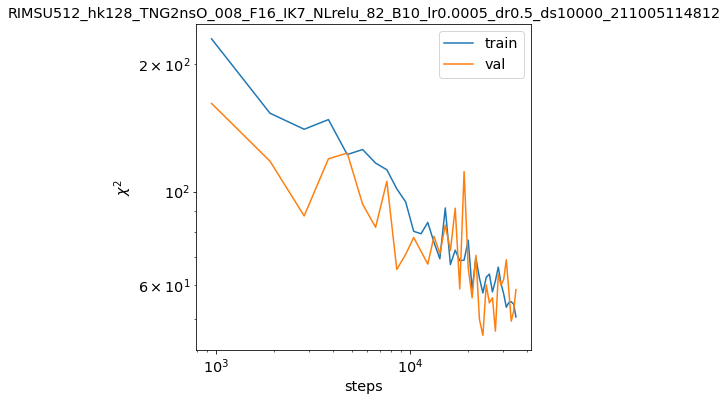

In [3]:
# title = "RIMSU512_hk128_TNG2nsO_005_F16_IK7_NLleaky_relu_82_B10_lr0.0005_dr0.9_ds1000_211005113627"
title = "RIMSU512_hk128_TNG2nsO_008_F16_IK7_NLrelu_82_B10_lr0.0005_dr0.5_ds10000_211005114812"
steps = histories[title]["step"].values()
train_chi = histories[title]["train_chi_squared"].values()
val_chi = histories[title]["val_chi_squared"].values()

# val_loss = histories[title]["val_cost"].values()

plt.figure(figsize=(6, 6))
plt.plot(steps, train_chi, label="train")
plt.plot(steps, val_chi, label="val")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$\chi^2$")
plt.xlabel("steps")
plt.title(title)
plt.legend();


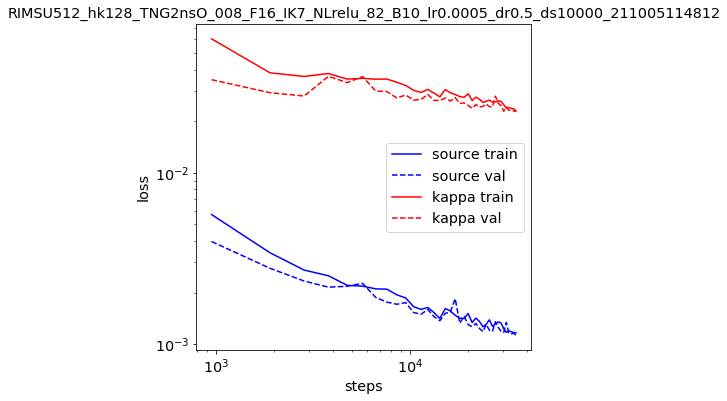

In [4]:
steps = histories[title]["step"].values()
train_kappa = histories[title]["train_kappa_cost"].values()
val_kappa = histories[title]["val_kappa_cost"].values()
train_source = histories[title]["train_source_cost"].values()
val_source = histories[title]["val_source_cost"].values()
# val_loss = histories[title]["val_cost"].values()

plt.figure(figsize=(6, 6))
plt.plot(steps, train_source, "b-", label="source train")
plt.plot(steps, val_source, "b--", label="source val")
plt.plot(steps, train_kappa, "r-", label="kappa train")
plt.plot(steps, val_kappa, "r--", label="kappa val")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"loss")
plt.xlabel("steps")
plt.title(title)
plt.legend();


In [5]:
# model = "RIMSU512_k128_NIEs_019_TI1000_32_B5_210918011431"
# model = "RIMSU512_k128_NIEs_017_TI1000_16_B5_210918010833"
# model = "RIMSU512_k128_NIE2nsvdO_033_TS10_F16_L5_IK11_NLrelu_al0.04_GAplus_42_B10_lr0.0005_dr0.8_ds5000_TWquadratic_210923032150"
# dataset = "lenses512_k128_NIE_10k_verydiffuse"
model = "RIMSU512_hk128_TNG2nsO_008_F16_IK7_NLrelu_82_B10_lr0.0005_dr0.5_ds10000_211005114812"
dataset = "lenses512_hk128_TNG100_10k_verydiffuse"

checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models", model)

with open(os.path.join(checkpoints_dir, "script_params.json"), "r") as f:
    args = json.load(f)
args = Namespace(**args)

tf.random.set_seed(args.seed)
np.random.seed(args.seed)
files = []
for dataset in [os.path.join(os.getenv('CENSAI_PATH'), "data", dataset)]:
    files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
np.random.shuffle(files)
# Read concurrently from multiple records
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"),
                           block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
# Read off global parameters from first example in dataset
for physical_params in dataset.map(decode_physical_model_info):
    break
dataset = dataset.map(decode_train).batch(1)
dataset = dataset.take(args.total_items).shuffle(1000, reshuffle_each_iteration=True)


In [9]:

phys = PhysicalModel(
    pixels=physical_params["pixels"].numpy(),
    kappa_pixels=physical_params["kappa pixels"].numpy(),
    src_pixels=physical_params["src pixels"].numpy(),
    image_fov=physical_params["image fov"].numpy(),
    kappa_fov=physical_params["kappa fov"].numpy(),
    src_fov=physical_params["source fov"].numpy(),
    method=args.forward_method,
    noise_rms=physical_params["noise rms"].numpy(),
    psf_sigma=physical_params["psf sigma"].numpy()
)

# unet = SharedUnetModel(
#     filters=args.filters,
#     filter_scaling=args.filter_scaling,
#     kernel_size=args.kernel_size,
#     layers=args.layers,
#     block_conv_layers=args.block_conv_layers,
#     strides=args.strides,
#     bottleneck_kernel_size=args.bottleneck_kernel_size,
#     bottleneck_filters=args.bottleneck_filters,
#     resampling_kernel_size=args.resampling_kernel_size,
#     gru_kernel_size=args.gru_kernel_size,
#     upsampling_interpolation=args.upsampling_interpolation,
#     kernel_regularizer_amp=args.kernel_regularizer_amp,
#     bias_regularizer_amp=args.bias_regularizer_amp,
#     activation=args.activation,
#     alpha=args.alpha,
#     initializer=args.initializer,
# )
unet = SharedUnetModel(
    filters=args.filters,
    filter_scaling=args.filter_scaling,
    kernel_size=args.kernel_size,
    layers=args.layers,
    block_conv_layers=args.block_conv_layers,
    strides=args.strides,
    bottleneck_kernel_size=args.bottleneck_kernel_size,
    bottleneck_filters=args.bottleneck_filters,
    resampling_kernel_size=args.resampling_kernel_size,
    input_kernel_size=args.input_kernel_size,
    gru_kernel_size=args.gru_kernel_size,
    upsampling_interpolation=args.upsampling_interpolation,
    kernel_l2_amp=args.kernel_l2_amp,
    bias_l2_amp=args.bias_l2_amp,
    kernel_l1_amp=args.kernel_l1_amp,
    bias_l1_amp=args.bias_l1_amp,
    activation=args.activation,
    alpha=args.alpha,
    initializer=args.initializer,
    batch_norm=args.batch_norm,
    dropout_rate=args.dropout_rate
)
rim = RIMSharedUnet(
    physical_model=phys,
    unet=unet,
    steps=args.steps,
    adam=args.adam,
    kappalog=args.kappalog,
    source_link=args.source_link,
    kappa_normalize=args.kappa_normalize,
    kappa_init=args.kappa_init,
    source_init=args.source_init
)
ckpt = tf.train.Checkpoint(net=rim.unet)
checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

199it [02:59,  1.11it/s]


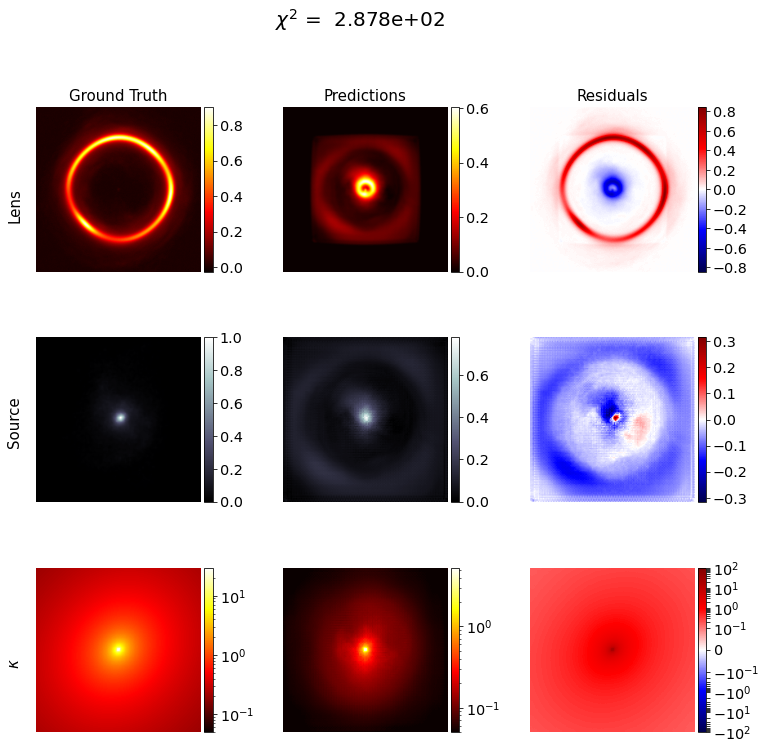

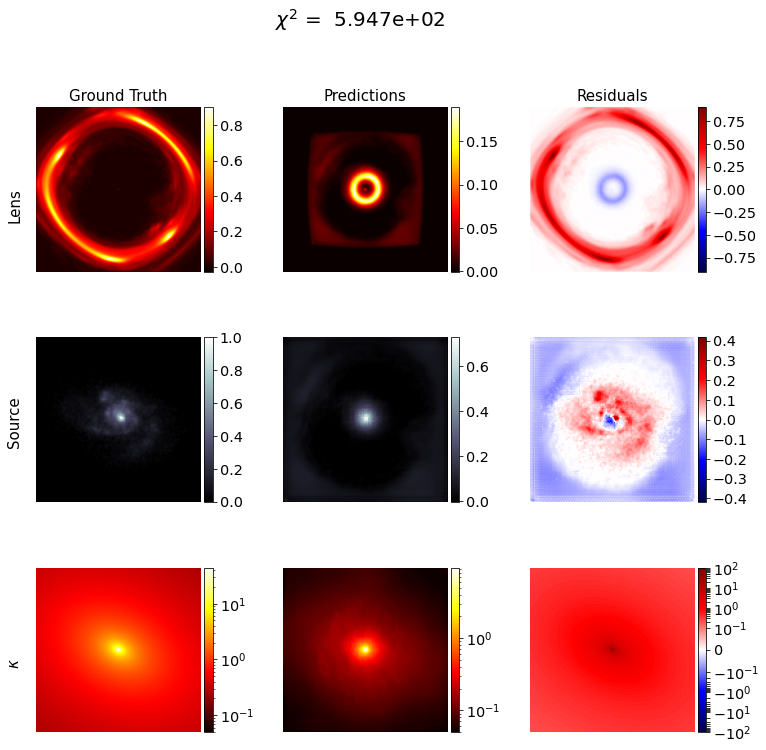

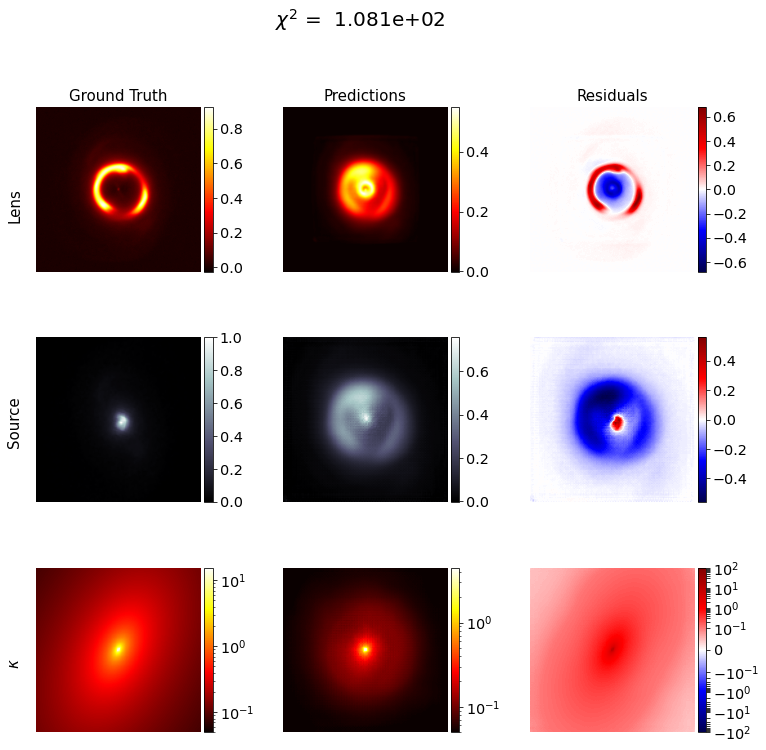

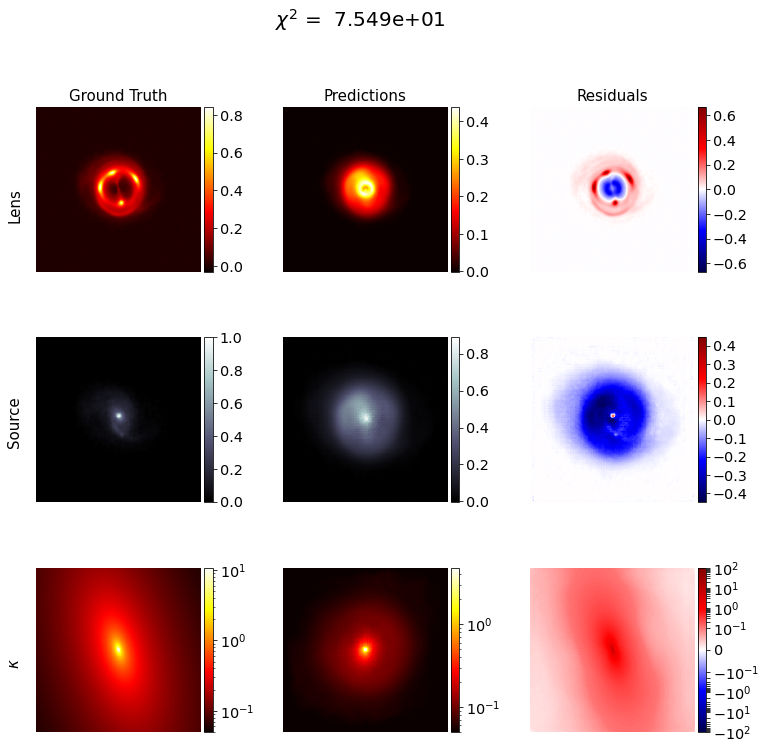

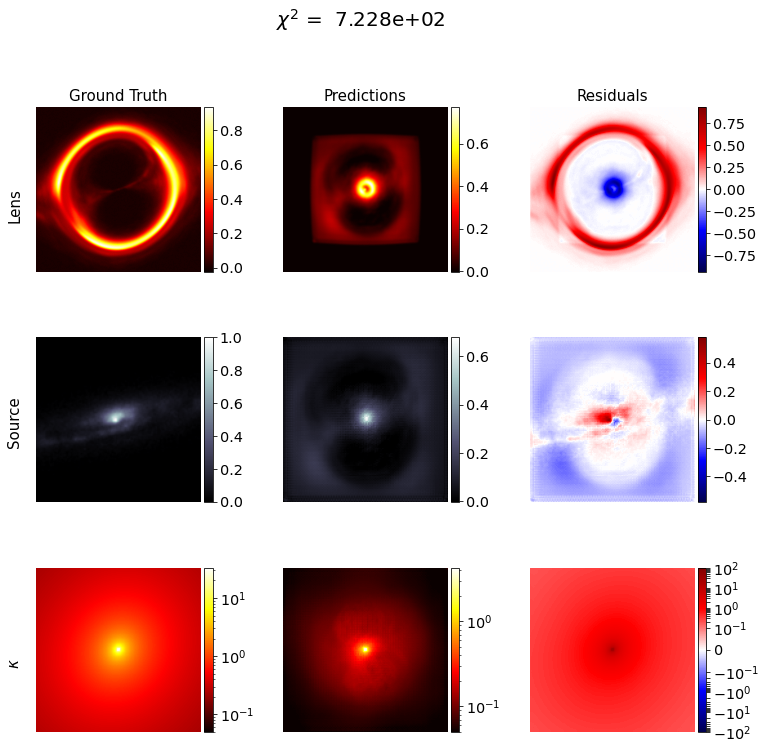

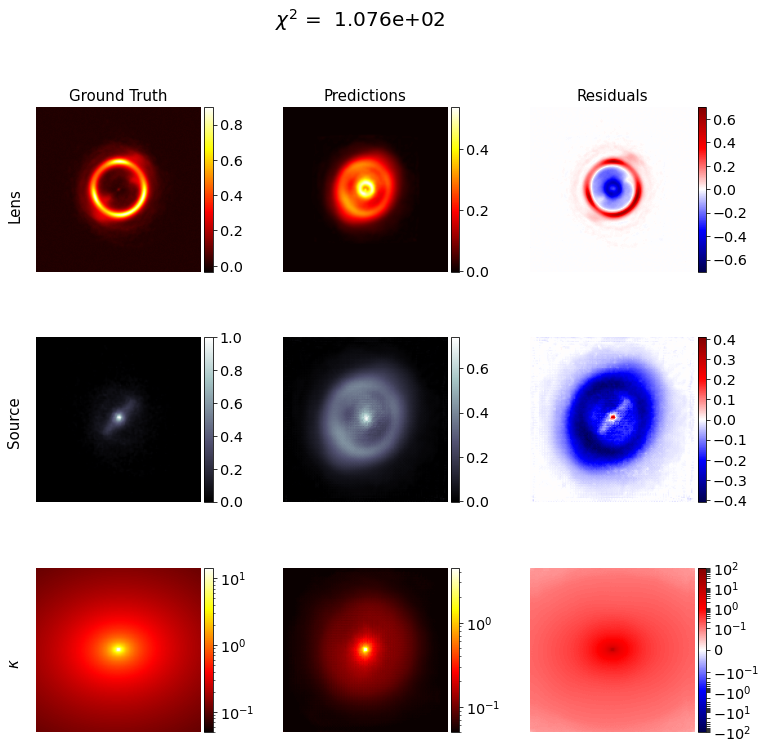

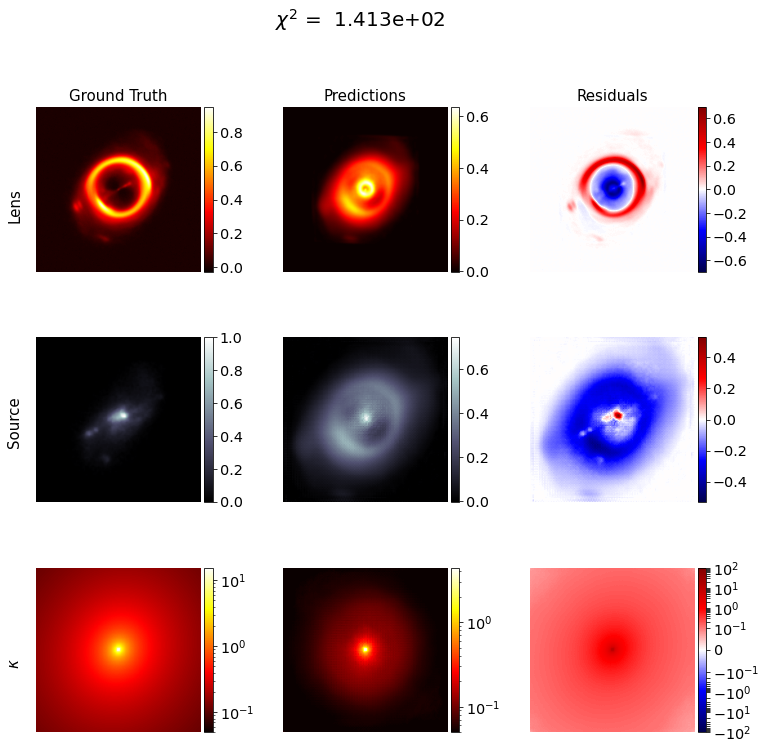

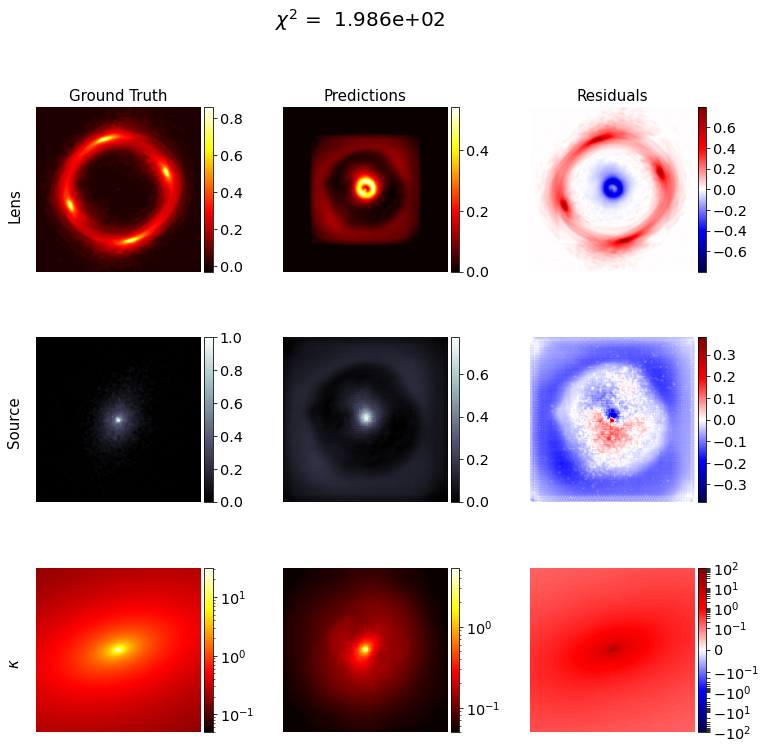

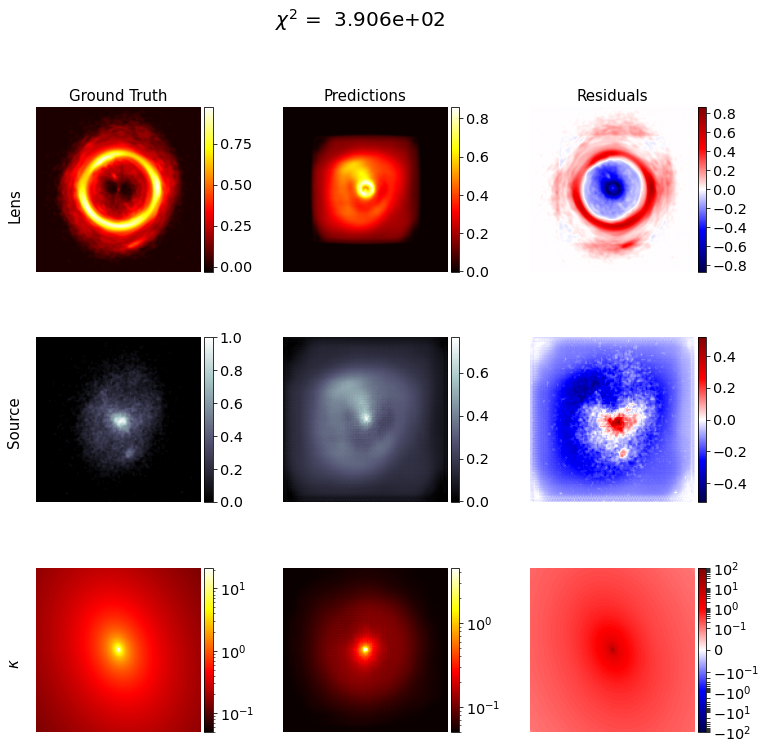

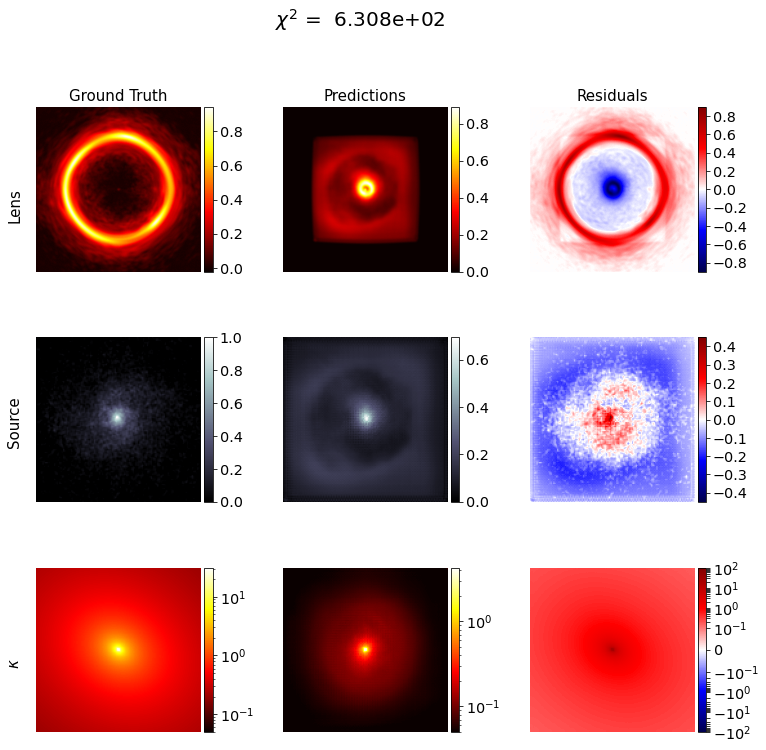

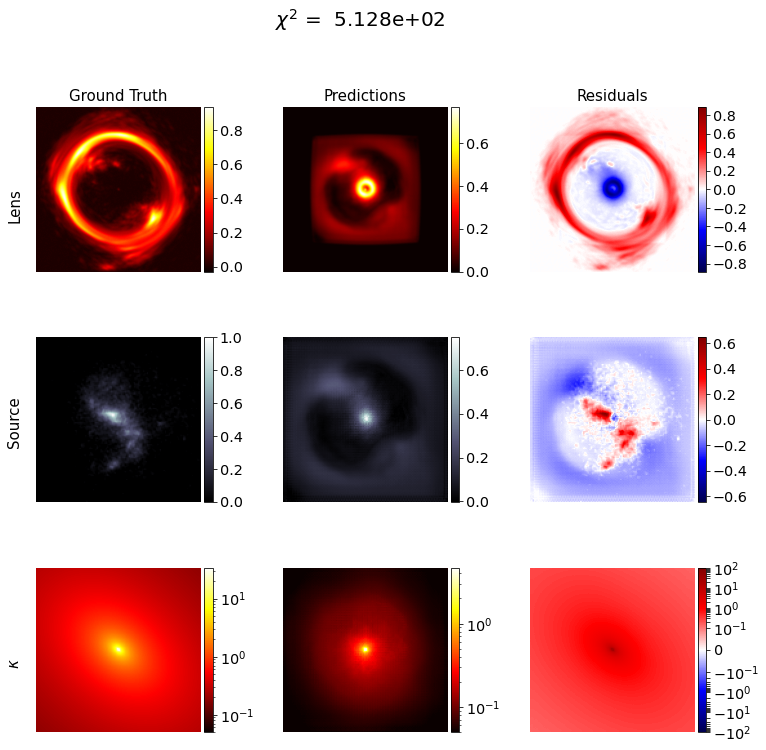

In [33]:
save = True

path = os.path.join(os.getenv('CENSAI_PATH'), "data", "rim_predictions", model)

i = 0
if save:
    if not os.path.isdir(path):
        os.mkdir(path)
    hf = h5py.File(os.path.join(path, "prediction.h5"), 'w')

for batch, (X, source, kappa) in tqdm(enumerate(dataset)):
    source_pred, kappa_pred, chi_squared = rim.predict(X)
    lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])
    lam = phys.lagrange_multiplier(y_true=X, y_pred=lens_pred)
    if save:
        g = hf.create_group(f'data{i:03d}' )
        g.create_dataset("lens",        data=X)
        g.create_dataset("source",      data=source)
        g.create_dataset("kappa",       data=kappa)
        g.create_dataset("lens_pred",   data=lens_pred)
        g.create_dataset("source_pred", data=source_pred)
        g.create_dataset("kappa_pred",  data=kappa_pred)
        g.create_dataset("chi_squared",  data=chi_squared)
        
    if i <= 10:
        rim_residual_plot(
            X[0], source[0], kappa[0], lam[0] * lens_pred[0], source_pred[-1][0],
            kappa_pred[-1][0], chi_squared[-1][0]
        )
        if not save and i == 10:
            break
    i += 1
    if i == 200:
        break
hf.close()